Download this corpus of BBC articles.  This corpus includes 2,225 documents from BBC's news website corresponding to stories in five topical areas (business, entertainment, politics, sport, tech) from 2004-2005. The CSV file includes two columns: category (the five class labels) and text (pre-processed article content). In this assignment, you will use only the text column. More information on this data set as well as a paper written using this data set is available at http://mlg.ucd.ie/datasets/bbc.html (Links to an external site.).

Most of the previous analyses of this data set examined multi-class classification, attempting to build classifiers to accurately predict the category of each article from its text. However, in this assignment, you will do something different: document tagging. Your job is to extract the top five keywords for each article that can be used for keyword search and retrieval. You can do this using LSI/LSA and LDA algorithms, after vectorizing the text using count vectors and TF-IDF vector. Your final deliverable for this assignment is the CSV file of articles (the input file) appended with four additional columns (with 10 keywords each): LSI with count vector, LSI with TF-IDF vector, LDA with count vector, LDA with TF-IDF vector, and a fifth column with the five most common keywords across these four groups of keywords, and your comment on which of these four methods worked best for this task. Also submit your code with intermediate processing results in a Jupyter file. Your code must have comment statements to describe the different steps you took to refine your topic model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import collections

In [4]:
data = pd.read_csv("BBC-articles.csv")
data.drop(['category'], 1, inplace=True)

In [7]:
articlelist = []

for i in data.text:
    articlelist.append(i)

In [8]:
len(articlelist)

2225

##  Fucntion to sort the list by frequency and getting 5 unique words from list !

In [204]:
def unique(list1):  
    from collections import Counter
    unique_list = [] 
    freqlist = [item for items, c in Counter(list1).most_common() for item in [items] * c] 
    for x in freqlist: 
        if x not in unique_list: 
            unique_list.append(x)
    return unique_list[0:5]

#Source : https://www.geeksforgeeks.org/python-get-unique-values-list/

## Optimum number of n_components - Example for SVD with CountVector for 1st 10 topics

Here, I am taking 10 articles as a sample to see on average what n_components the need to attain a total varience explained >= 0.9

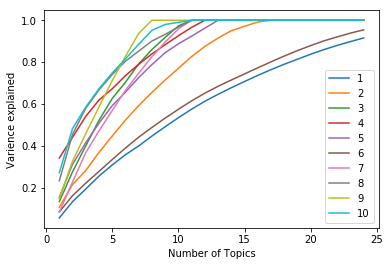

In [200]:
for doc in range(0,10):
    expvarince = []
    numoftopics = [] 
    for n in range(1,25):
        
        sentences = nltk.tokenize.sent_tokenize(articlelist[doc])
        from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
        vec_count = CountVectorizer(max_df= 0.85, lowercase=True, stop_words='english', token_pattern='[a-z]{3,}')
        countvector_dtm = vec_count.fit_transform(sentences)
        
        #LSA- CountVector
        from sklearn.decomposition import TruncatedSVD
        svd_model_CV = TruncatedSVD(n_components= n,algorithm='randomized', n_iter=100, random_state=42)
        svd_model_CV.fit(countvector_dtm)
        var_explained_svd_CV = svd_model_CV.explained_variance_ratio_.sum()
        expvarince.append(var_explained_svd_CV)
        numoftopics.append(n)

    import matplotlib.pyplot as plt
    plt.plot(numoftopics, expvarince)
    plt.xlabel('Number of Topics')
    plt.ylabel('Varience explained')
    plt.legend((numoftopics), loc='lower right')

The above plot shows that some articles required as much as 25 n_components(topics) while some converge at average 10 topics to get total variance explaned >= 0.9 

## Optimum number of n_components - Example for LDA with CountVector for 1st 10 topics

Similarly I am taking 10 articles as a sample to see on average how the perplexity value varies as we increase the number of topics for LDA model

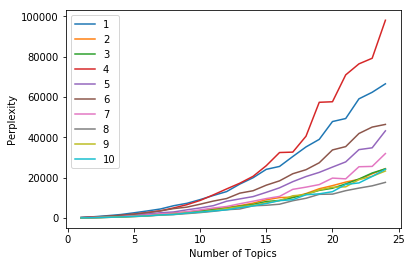

In [186]:
for doc in range(0,10):
    expvarince = []
    numoftopics = [] 
    for n in range(1,25):
        
        sentences = nltk.tokenize.sent_tokenize(articlelist[doc])
        from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
        vec_tfidf = TfidfVectorizer(max_df= 0.85, stop_words='english', lowercase=True, token_pattern='[a-z]{3,}') #If frequency of word exceeds 85% or more, remove that word
        tfidf_dtm = vec_tfidf.fit_transform(sentences)
        terms_tfidf = vec_tfidf.get_feature_names()
    
        #LDA-TFIDF
        lda_model_tfidf = LDA(n_components= n,max_iter = 100,random_state = 42, learning_decay=0.9) #Check for additional parameters
        lda_model_tfidf.fit(tfidf_dtm)
        var_explained_lda_tfidf = lda_model_tfidf.perplexity(tfidf_dtm)
        expvarince.append(var_explained_lda_tfidf)
        numoftopics.append(n)

    import matplotlib.pyplot as plt
    plt.plot(numoftopics, expvarince)
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    plt.legend((numoftopics), loc='upper left')

For a good LDA model, perplexity should be as low as possible. Looking at the graph, all the perplexity values starts exponentially increasing after 6 topics. Hence I will be limiting the number of topics for LDA models from 1 to 6

# Code for 2225 documents with control for n_components for each method

In [201]:
data['top5_LSI_CV'] = ''
data['top5_LSI_TFIDF'] = ''
data['top5_LDA_CV'] = ''
data['top5_LDA_TFIDF'] = ''
data['top5_All'] = ''
componentlist = [svd_model_CV.components_,svd_model_tfidf.components_,lda_model_CV.components_,lda_model_tfidf.components_]
c = 0

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec_count = CountVectorizer(max_df= 0.85, lowercase=True, stop_words='english', token_pattern='[a-z]{3,}')
vec_tfidf = TfidfVectorizer(max_df= 0.85, stop_words='english', lowercase=True, token_pattern='[a-z]{3,}') #If frequency of word exceeds 85% or more, remove that word

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA

for doc in range(len(articlelist)):
    sentences = nltk.tokenize.sent_tokenize(articlelist[doc])
    
    countvector_dtm = vec_count.fit_transform(sentences)
    terms_CV = vec_count.get_feature_names()
    
    tfidf_dtm = vec_tfidf.fit_transform(sentences)
    terms_tfidf = vec_tfidf.get_feature_names()
    
    for n in range(1,50):
        #LSA- CountVector
        svd_model_CV = TruncatedSVD(n_components= n,algorithm='randomized', n_iter=100, random_state=42)
        svd_model_CV.fit(countvector_dtm) 
        variance_explained_CV = svd_model_CV.explained_variance_ratio_.sum()
        if (variance_explained_CV <=0.9):
            continue
        else:
            break
        
    for n in range(1,50):
        #LSA- TFIDF
        svd_model_tfidf = TruncatedSVD(n_components= n,algorithm='randomized', n_iter=100, random_state=42)
        svd_model_tfidf.fit(tfidf_dtm)
        variance_explained_tfidf = svd_model_tfidf.explained_variance_ratio_.sum()
        if (variance_explained_tfidf <=0.9):
            continue
        else:
            break
        
    for n in range(1,6):
        #LDA-CountVector
        lda_model_CV = LDA(n_components = n,max_iter = 100,random_state = 42, learning_decay=0.9)
        lda_model_CV.fit(countvector_dtm)
        var_explained_lda_CV = lda_model_CV.perplexity(countvector_dtm)
        if (var_explained_lda_CV <= 500): #based on the graph drawn above
            continue
        else:
            break
        
    for n in range(1,6):
        #LDA-TFIDF
        lda_model_tfidf = LDA(n_components= n,max_iter = 100,random_state = 42, learning_decay=0.9)
        lda_model_tfidf.fit(tfidf_dtm)
        var_explained_lda_tfidf = lda_model_tfidf.perplexity(tfidf_dtm)
        if (var_explained_lda_tfidf <= 500): #based on the graph drawn above
            continue
        else:
            break

    words = []
    for component in componentlist:
        allterms = []
        comp5_term = []
        for comp in component:
            if (component == 'svd_model_CV.components_') | (component == 'lda_model_CV.components_'):
                term = terms_CV
            else:
                term = terms_tfidf
                terms_comp = zip(term, comp)
                sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:5]
                for m in sorted_terms:
                    allterms.append(m[0]) #Appending all the top 5 terms generated by each n_componenet(topic number) of all model.component_
            comp5_term = unique(allterms) #Finding 5 most frequent word from allterms for one model type (5 keywords for each method)
        for t in comp5_term:
            words.append(t) #appending those 5 words in master list of word for this document.
                            #In the end we will get 5 most frequent word from this list to append in last column

    master5_words = unique(words)

    data.iloc[doc,1] = words[0:5] #appending 5 words from LSI_CountVector
    data.iloc[doc,2] = words[5:10] #appending 5 words from LSI_TFIDF
    data.iloc[doc,3] = words[10:15] #appending 5 words from LDA_CountVector
    data.iloc[doc,4] = words[15:20] #appending 5 words from LDA_TFIDF
    data.iloc[doc,5] = master5_words #Top 5 words from all

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [203]:
data.to_csv('TA_Rushikesh_Assignment3_BBC-articles_Results.csv')

In [5]:
result = pd.read_csv("TA_Rushikesh_Assignment3_BBC-articles_Results.csv")

In [6]:
result.head()

,Unnamed: 0,text,top5_LSI_CV,top5_LSI_TFIDF,top5_LDA_CV,top5_LDA_TFIDF,top5_All
0,0,tv future in the hands of viewers with home th...,"['built', 'crystal', 'europe', 'future', 'dire...","['consumer', 'choice', 'familiar', 'pause', 'g...","['familiar', 'ces', 'consumer', 'moving', 'old...","['ces', 'choice', 'older', 'moving', 'diapers']","['consumer', 'choice', 'familiar', 'ces', 'mov..."
1,1,worldcom boss left books alone former worldc...,"['competition', 'fraud', 'left', 'overseeing',...","['entries', 'financial', 'mastermind', 'prosec...","['mastermind', 'admitted', 'defence', 'financi...","['defence', 'entries', 'hidden', 'jobs', 'darl...","['entries', 'financial', 'mastermind', 'hidden..."
2,2,tigers wary of farrell gamble leicester say ...,"['decides', 'make', 'row', 'sure', 'option']","['initially', 'leicester', 'say', 'wary', 'mom...","['say', 'backs', 'gamble', 'leicester', 'step']","['gamble', 'initially', 'moment', 'position', ...","['initially', 'leicester', 'say', 'moment', 'g..."
3,3,yeading face newcastle in fa cup premiership s...,"['city', 'fulham', 'january', 'martin', 'hart']","['face', 'draw', 'league', 'yeading', 'non']","['league', 'cup', 'face', 'united', 'west']","['cup', 'draw', 'west', 'united', 'goalless']","['face', 'draw', 'league', 'cup', 'united']"
4,4,ocean s twelve raids box office ocean s twelve...,"['december', 'gone', 'master', 'pack', 'joins']","['fellman', 'fun', 'national', 'raids', 'heists']","['national', 'beat', 'elliott', 'fun', 'opening']","['elliott', 'fellman', 'heists', 'just', 'dire...","['fellman', 'fun', 'national', 'heists', 'elli..."


<b>After manually eye-balling some of the documents and corresponding keywords generated by 4 methods, It is observered that LSI  model  with  TFIDF and LDA  model  with  TFIDF works the best as 3 of their key words are present in other models too which justifies it's importance as a keyword for search

# Extra Credit - Custom TF-IDF vectorizer

Extra-credit: For an additional 5 bonus points, your can write your own custom Python code to create different variants of TF and IDF weights described in the tables on Wikipedia's TF-IDF page: https://en.wikipedia.org/wiki/Tf–idf (Links to an external site.)to see if you can improve upon your prior results. You will recognize that two of these variants are the standard count vector and TF-IDF vector that you already used in this assignment (using sklearn's CountVectorizer() and TfidfVectorizer() or Gensim's doc2bow() or TfidfModel() functions). Writing this code is not difficult, just needs a little patience. Check out if your own Count Vectorizer and Tfidf Vectorizer functions yield results similar to what you get from sklearn's and Gensim's library functions.


### Term Frequency - Log Normalized

In [79]:
import math

def tfLogNorm(doc):
    stop_words = nltk.corpus.stopwords.words('english')
    allwords = []
    TFLN = {}
    sentences = nltk.tokenize.sent_tokenize(doc)
    for i in range(len(sentences)):
        words = nltk.tokenize.word_tokenize(sentences[i])
        allwords = words + allwords
    
        allwords = [w for w in allwords if w not in stop_words]
        allwords = [w for w in allwords if len(w) >2]
    
        for w in allwords:
            freq = allwords.count(w)
            wvalue = math.log(1 + freq)
            TFLN[w] = wvalue
            filter(lambda a: a != w, allwords)
    return TFLN
    

In [80]:
a = articlelist[0]
tf_a = tfLogNorm(a)
tf_a

{'future': 1.0986122886681098,
 'hands': 1.0986122886681098,
 'viewers': 1.3862943611198906,
 'home': 1.0986122886681098,
 'theatre': 0.6931471805599453,
 'systems': 0.6931471805599453,
 'plasma': 0.6931471805599453,
 'high-definition': 1.6094379124341003,
 'tvs': 1.0986122886681098,
 'digital': 1.0986122886681098,
 'video': 1.0986122886681098,
 'recorders': 1.0986122886681098,
 'moving': 0.6931471805599453,
 'living': 0.6931471805599453,
 'room': 0.6931471805599453,
 'way': 1.0986122886681098,
 'people': 2.0794415416798357,
 'watch': 1.6094379124341003,
 'radically': 0.6931471805599453,
 'different': 0.6931471805599453,
 'five': 0.6931471805599453,
 'years': 1.0986122886681098,
 'time': 1.0986122886681098,
 'according': 0.6931471805599453,
 'expert': 0.6931471805599453,
 'panel': 1.0986122886681098,
 'gathered': 0.6931471805599453,
 'annual': 0.6931471805599453,
 'consumer': 1.0986122886681098,
 'electronics': 0.6931471805599453,
 'show': 1.3862943611198906,
 'las': 0.6931471805599453

### Inverse Document Frequency Smooth

In [91]:
def idfS(doc):
    stop_words = nltk.corpus.stopwords.words('english')
    allwords = []
    idfS = {}
    uniquewords = []
    sentences = nltk.tokenize.sent_tokenize(doc)
    N = len(sentences)

    for i in range(len(sentences)):
        words = nltk.tokenize.word_tokenize(sentences[i])
        allwords = words + allwords

    for j in allwords:
        if j not in uniquewords:
            uniquewords.append(j)
        else:
            continue
    docwordcount= {}
    for i in sentences:
        words = nltk.tokenize.word_tokenize(i)
        for w in uniquewords:
            if w in words:
                docnum = docnum + 1
            else:
                docnum = 0
                docwordcount[w]=docnum

    return docwordcount
            
            

In [93]:
a = articlelist[0]
idfS_a = idfS(a)
idfS_a

#Could not complete !!

{'all': 0,
 'these': 0,
 'reflect': 0,
 'increasing': 0,
 'trend': 0,
 'freeing': 0,
 'up': 0,
 'multimedia': 0,
 'so': 0,
 'that': 0,
 'can': 0,
 'what': 0,
 'they': 0,
 'want': 0,
 'when': 0,
 'microsoft': 0,
 'chief': 0,
 'bill': 0,
 'gates': 0,
 'announced': 0,
 'his': 0,
 'pre-show': 0,
 'keynote': 0,
 'speech': 0,
 'a': 0,
 'partnership': 0,
 'tivo': 0,
 'called': 0,
 'tivotogo': 0,
 'which': 0,
 'means': 0,
 'play': 0,
 'recorded': 0,
 'programmes': 0,
 'on': 0,
 'windows': 0,
 'pcs': 0,
 'mobile': 0,
 'devices': 0,
 'set': 0,
 'pause': 0,
 'rewind': 0,
 'for': 0,
 'to': 0,
 '90': 0,
 'hours': 0,
 'one': 0,
 'us': 0,
 's': 0,
 'biggest': 0,
 'satellite': 0,
 'companies': 0,
 'directtv': 0,
 'has': 0,
 'even': 0,
 'launched': 0,
 'its': 0,
 'own': 0,
 'branded': 0,
 'dvr': 0,
 'at': 0,
 'show': 0,
 '100-hours': 0,
 'recording': 0,
 'capability': 0,
 'instant': 0,
 'replay': 0,
 'search': 0,
 'function': 0,
 'such': 0,
 'example': 0,
 'is': 0,
 'humax': 0,
 '26-inch': 0,
 'lcd': 0

# Could not Complete